In [152]:
%pip install "psycopg[binary,pool]" tensorflow matplotlib seaborn



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [153]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [154]:
import psycopg
import os

os.environ['PGSERVICEFILE'] = "/home/martin/Workspace/Energiegemeinschaft/notebooks/.pg_service.conf"
os.environ['PGPASSFILE'] = "/home/martin/Workspace/Energiegemeinschaft/notebooks/.pgpass"

with psycopg.connect(service='eeg-middleware') as conn:
    with conn.cursor() as cur:
        sql = """
            select m.value * 4.0 as kilowatt_production, 
            w.temperature_2m,
            w. cloud_cover, 
            w.time
            from weather_weatherdata w
            inner join metering_measurement m on m.timestamp = w.time
            inner join public.members_measurementpoint mm on mm.id = m.measurement_point_id
            inner join public.members_member member on member.id = mm.member_id
            where m.meter_code_id = 196
            and member.identifier = 1
            order by w.time desc;
        """
        cur.execute(sql)
        rows = cur.fetchall()
        df = pd.DataFrame(rows, columns=[desc[0] for desc in cur.description])

In [155]:
df

,kilowatt_production,temperature_2m,cloud_cover,time
0,0E-11,19.0,33.0,2025-07-05 21:00:00+02:00
1,0E-11,19.7,18.0,2025-07-05 20:00:00+02:00
2,0E-11,20.9,74.0,2025-07-05 19:00:00+02:00
3,0.07300000000,22.0,100.0,2025-07-05 18:00:00+02:00
4,1.03800000000,22.8,100.0,2025-07-05 17:00:00+02:00
...,...,...,...,...
12902,0E-11,-0.2,100.0,2024-01-15 04:00:00+01:00
12903,0E-11,-2.0,99.0,2024-01-15 03:00:00+01:00
12904,0E-11,0.3,79.0,2024-01-15 02:00:00+01:00
12905,0E-11,-0.4,100.0,2024-01-15 01:00:00+01:00


In [156]:
df.describe()

,temperature_2m,cloud_cover
count,12907.000000,12907.000000
mean,10.740490,65.253506
std,8.313932,40.456638
min,-14.500000,0.000000
25%,4.100000,21.000000
50%,10.200000,92.000000
75%,17.150000,100.000000
max,34.000000,100.000000


In [157]:
df.head()  

,kilowatt_production,temperature_2m,cloud_cover,time
0,0E-11,19.0,33.0,2025-07-05 21:00:00+02:00
1,0E-11,19.7,18.0,2025-07-05 20:00:00+02:00
2,0E-11,20.9,74.0,2025-07-05 19:00:00+02:00
3,0.07300000000,22.0,100.0,2025-07-05 18:00:00+02:00
4,1.03800000000,22.8,100.0,2025-07-05 17:00:00+02:00


In [158]:
# Fixing data frame

df['kilowatt_production'] = pd.to_numeric(df['kilowatt_production'], errors='coerce')



In [159]:
date_time = pd.to_datetime(df.pop('time'), format='%d.%m.%Y %H:%M:%S')


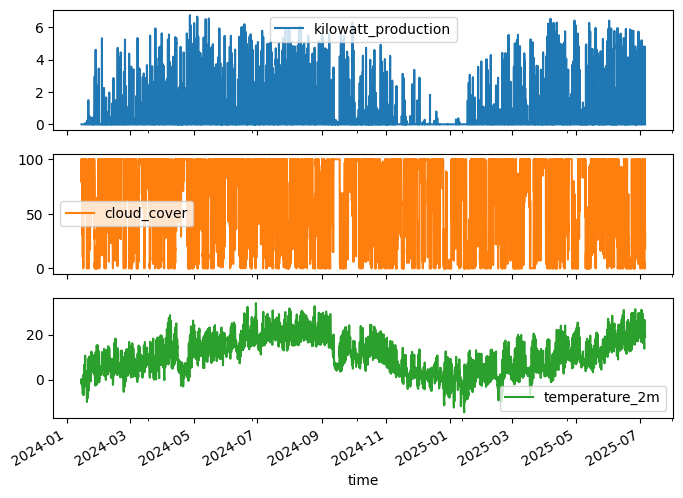

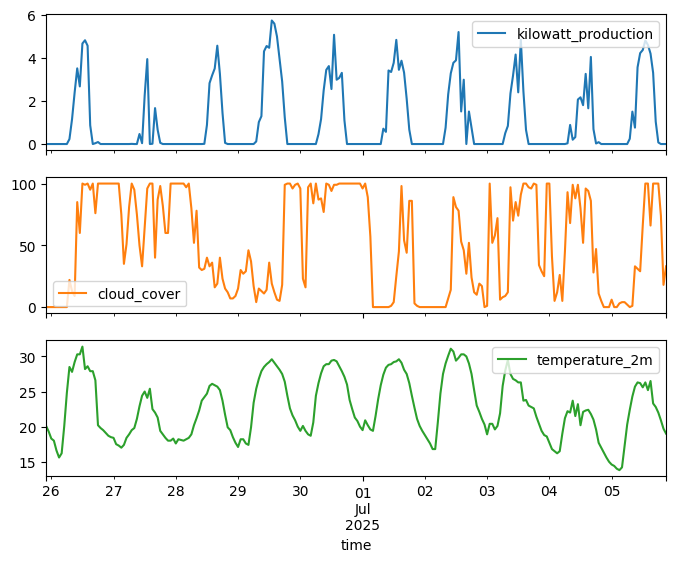

In [160]:
plot_cols = ['kilowatt_production', 'cloud_cover', 'temperature_2m']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:240]
plot_features.index = date_time[:240]
_ = plot_features.plot(subplots=True)

In [161]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
kilowatt_production,12907.0,0.532784,1.206212,0.0,0.0,0.0,0.1705,6.735
temperature_2m,12907.0,10.740490,8.313932,-14.5,4.1,10.2,17.1500,34.000
cloud_cover,12907.0,65.253506,40.456638,0.0,21.0,92.0,100.0000,100.000


# Feature engineering

In [162]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

In [163]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

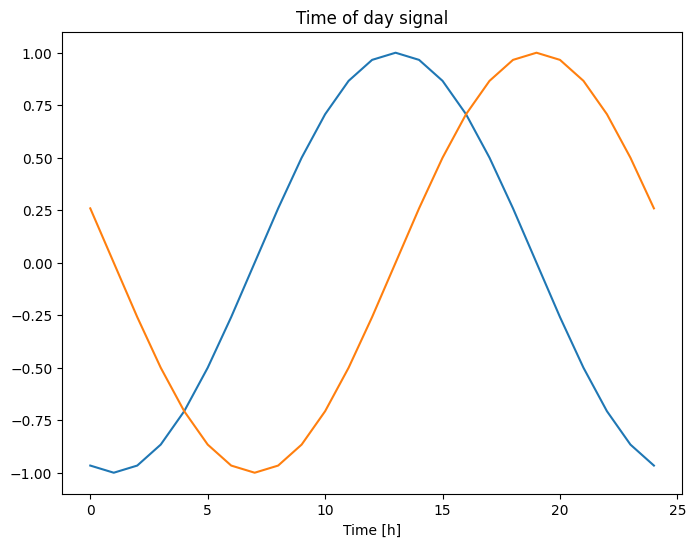

In [164]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

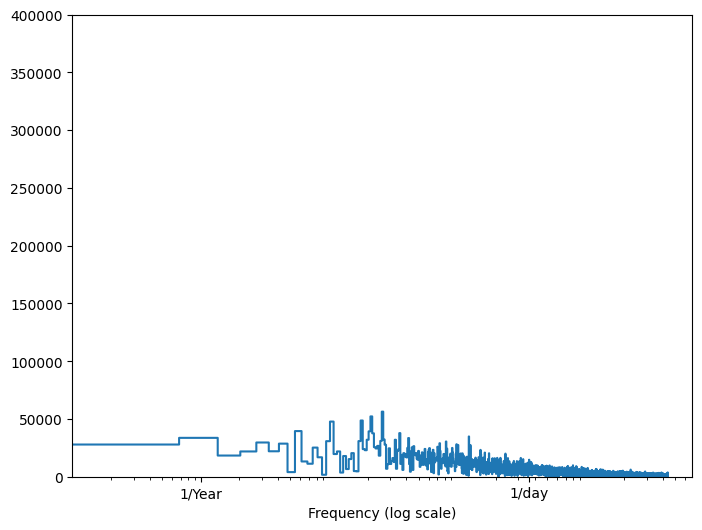

In [165]:
fft = tf.signal.rfft(df['cloud_cover'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['cloud_cover'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

split data in train, validate, test

In [166]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]
num_features

7

In [167]:
column_indices

{'kilowatt_production': 0,
 'temperature_2m': 1,
 'cloud_cover': 2,
 'Day sin': 3,
 'Day cos': 4,
 'Year sin': 5,
 'Year cos': 6}

normalize data

In [168]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

/tmp/ipykernel_26238/3214313372.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df.keys(), rotation=90)


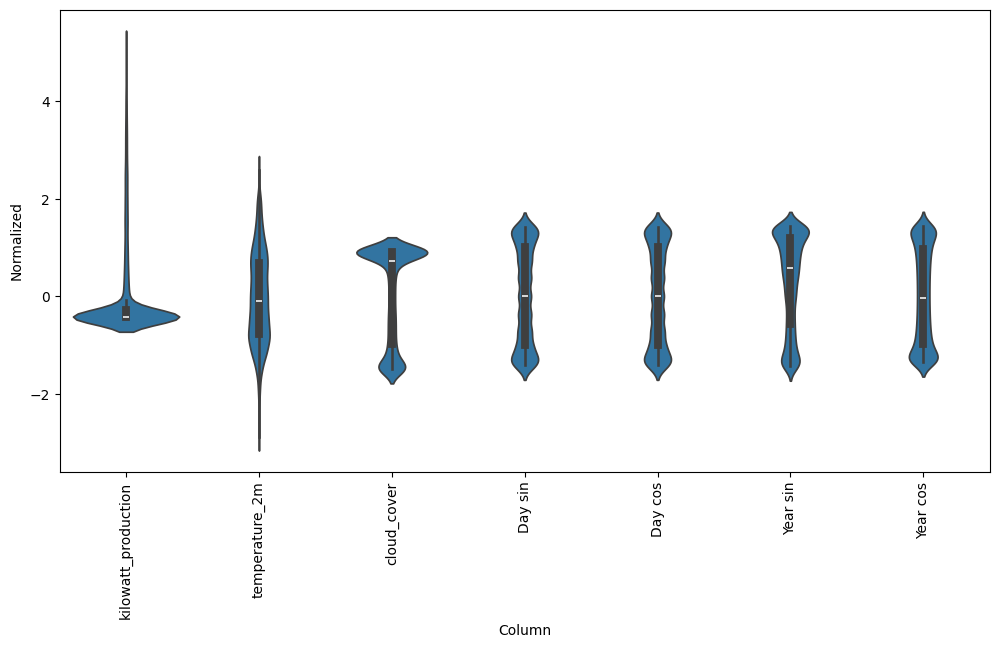

In [169]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [170]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])


In [171]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['kilowatt_production'])

In [172]:
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['kilowatt_production']

In [173]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [174]:
w2 = WindowGenerator(input_width=48, label_width=1, shift=1,
                     label_columns=['kilowatt_production'])
w2

Total window size: 49
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label indices: [48]
Label column name(s): ['kilowatt_production']

In [175]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 49, 7)
Inputs shape: (3, 48, 7)
Labels shape: (3, 1, 1)


In [176]:
w2.example = example_inputs, example_labels

def plot(self, model=None, plot_col='kilowatt_production', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

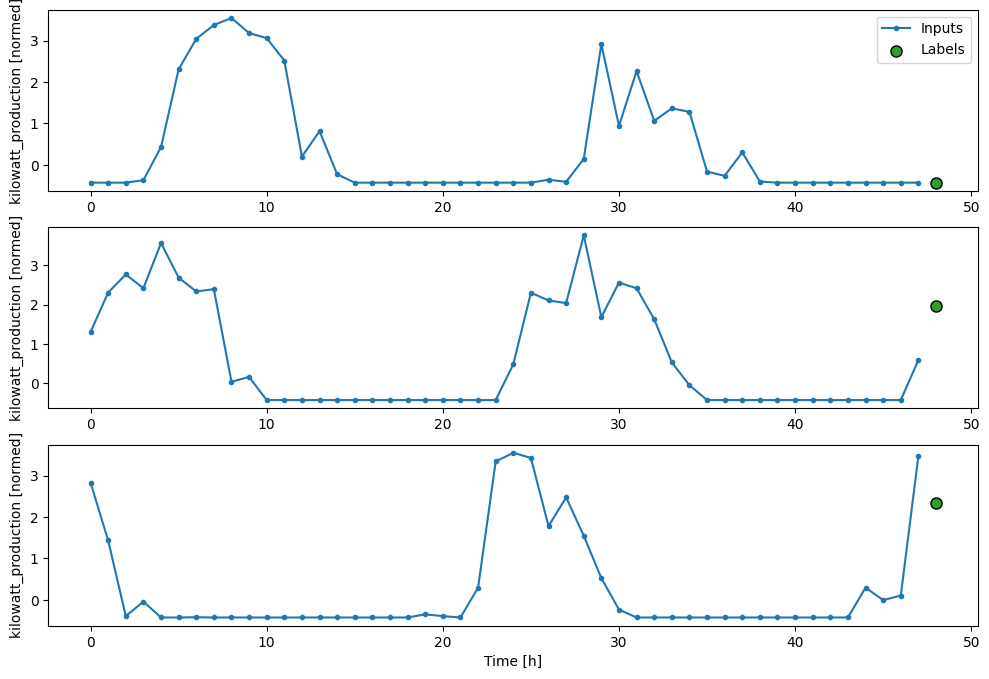

In [177]:
w2.plot()

In [178]:
def plot(self, model=None, plot_col='temperature_2m', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [179]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [180]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example


In [181]:
w2.train.element_spec

(TensorSpec(shape=(None, 48, 7), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [182]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['kilowatt_production'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['kilowatt_production']

In [183]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')


Inputs shape (batch, time, features): (32, 1, 7)
Labels shape (batch, time, features): (32, 1, 1)


In [184]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [185]:
baseline = Baseline(label_index=column_indices['kilowatt_production'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val, return_dict=True)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0, return_dict=True)


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - loss: 0.5806 - mean_absolute_error: 0.3874


In [ ]:
wide_window = WindowGenerator(
    input_width=48, label_width=48, shift=1,
    label_columns=['kilowatt_production'])

wide_window

Total window size: 49
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label indices: [25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48]
Label column name(s): ['kilowatt_production']

ValueError: x and y must be the same size

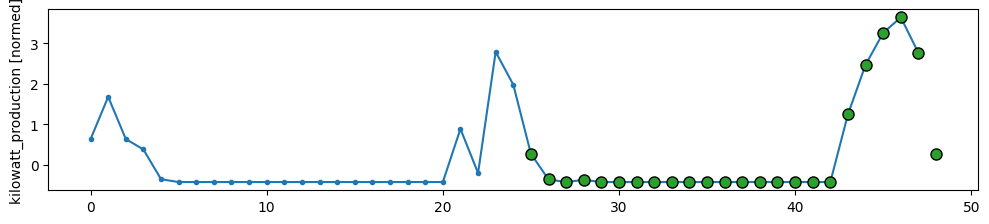

In [187]:
wide_window.plot(baseline, plot_col='kilowatt_production')

In [ ]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [ ]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history


In [ ]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val, return_dict=True)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0, return_dict=True)


Epoch 1/20
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 2.2894 - mean_absolute_error: 1.0768 - val_loss: 1.2638 - val_mean_absolute_error: 0.7336
Epoch 2/20
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - loss: 1.0309 - mean_absolute_error: 0.6799 - val_loss: 0.7879 - val_mean_absolute_error: 0.5766
Epoch 3/20
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - loss: 0.6718 - mean_absolute_error: 0.5622 - val_loss: 0.6279 - val_mean_absolute_error: 0.5250
Epoch 4/20
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - loss: 0.5362 - mean_absolute_error: 0.5113 - val_loss: 0.5586 - val_mean_absolute_error: 0.4949
Epoch 5/20
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - loss: 0.4732 - mean_absolute_error: 0.4759 - val_loss: 0.5185 - val_mean_absolute_error: 0.4722
Epoch 6/20
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step - loss: 0.4271 - mean_absolute_error: 0.4422 - val_loss: 0.4948 - val_mean_absolute_error: 0.4547
Epoch 7/20
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - loss: 0.3986 - mean_absolute_err

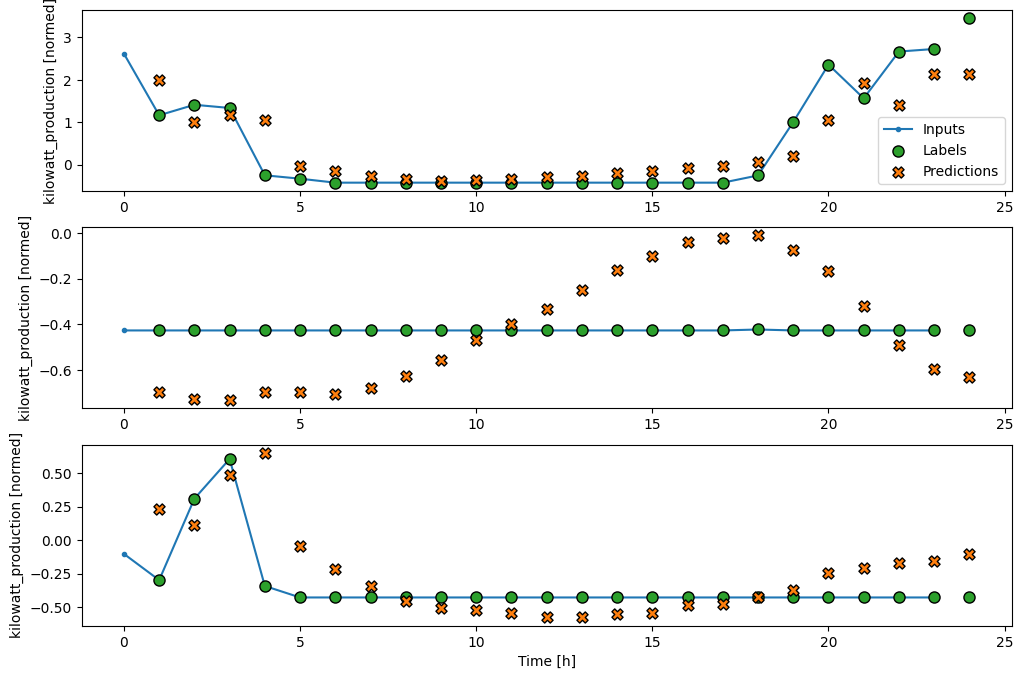

In [ ]:
wide_window.plot(linear, plot_col='kilowatt_production')

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val, return_dict=True)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0, return_dict=True)


Epoch 1/20
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4505 - mean_absolute_error: 0.3505 - val_loss: 0.4079 - val_mean_absolute_error: 0.3430
Epoch 2/20
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - loss: 0.2536 - mean_absolute_error: 0.2449 - val_loss: 0.4111 - val_mean_absolute_error: 0.3423
Epoch 3/20
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - loss: 0.2478 - mean_absolute_error: 0.2385 - val_loss: 0.4197 - val_mean_absolute_error: 0.3378
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step - loss: 0.4418 - mean_absolute_error: 0.3510


In [ ]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['kilowatt_production'])

conv_window


Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['kilowatt_production']

Text(0.5, 0.98, 'Given 3 hours of inputs, predict 1 hour into the future.')

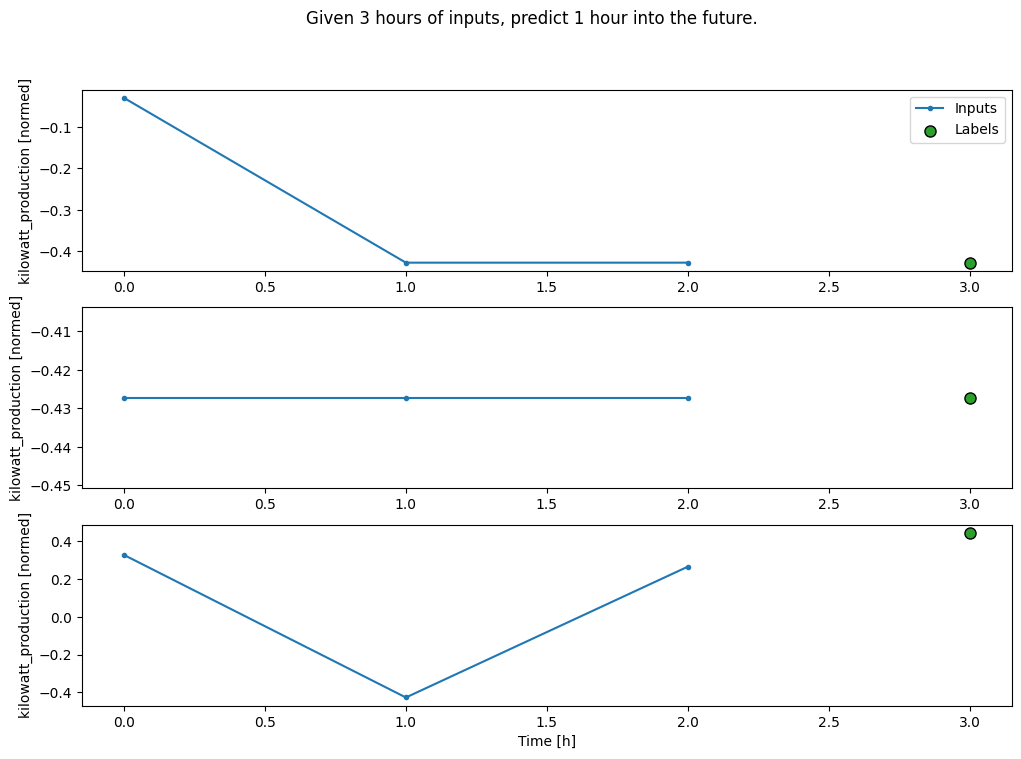

In [ ]:
conv_window.plot(plot_col='kilowatt_production')
plt.suptitle("Given 3 hours of inputs, predict 1 hour into the future.")


In [ ]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])


In [ ]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)


Input shape: (32, 3, 7)
Output shape: (32, 1, 1)


In [ ]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val, return_dict=True)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0, return_dict=True)


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - loss: 0.4135 - mean_absolute_error: 0.3427


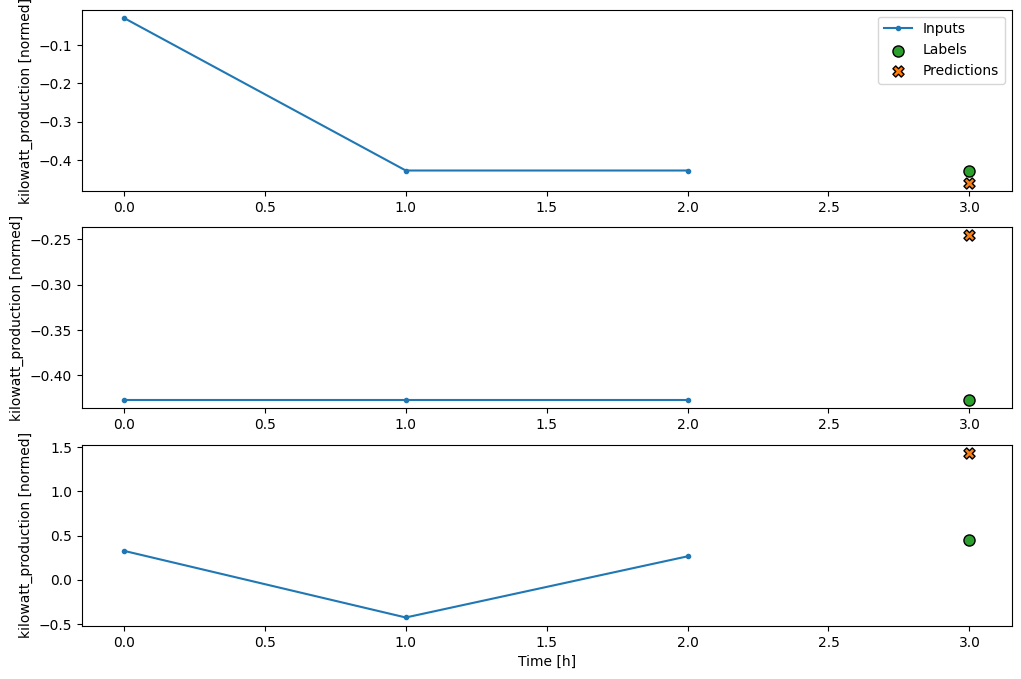

In [ ]:
conv_window.plot(multi_step_dense, plot_col='kilowatt_production')

In [ ]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])


In [ ]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)


Conv model on `conv_window`
Input shape: (32, 3, 7)
Output shape: (32, 1, 1)


In [ ]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val, return_dict=True)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0, return_dict=True)


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - loss: 0.4129 - mean_absolute_error: 0.3418


In [ ]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)


Wide window
Input shape: (32, 24, 7)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


In [ ]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['kilowatt_production'])

wide_conv_window


Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['kilowatt_production']

In [ ]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)


Wide conv window
Input shape: (32, 26, 7)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


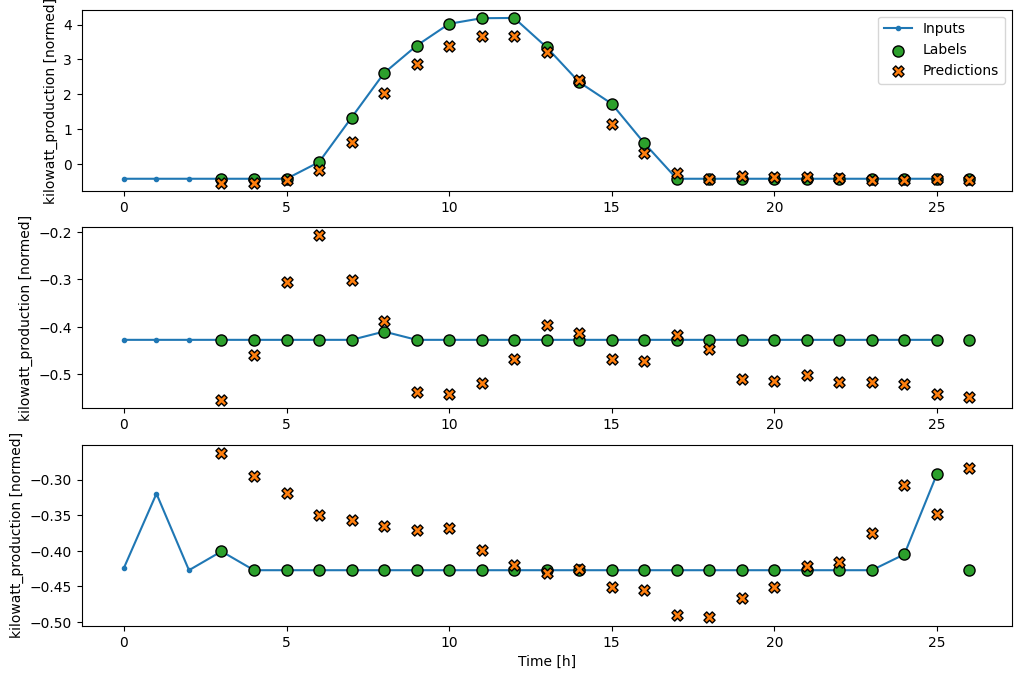

In [ ]:
wide_conv_window.plot(conv_model, plot_col='kilowatt_production')


In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val, return_dict=True)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0, return_dict=True)


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4116 - mean_absolute_error: 0.3389


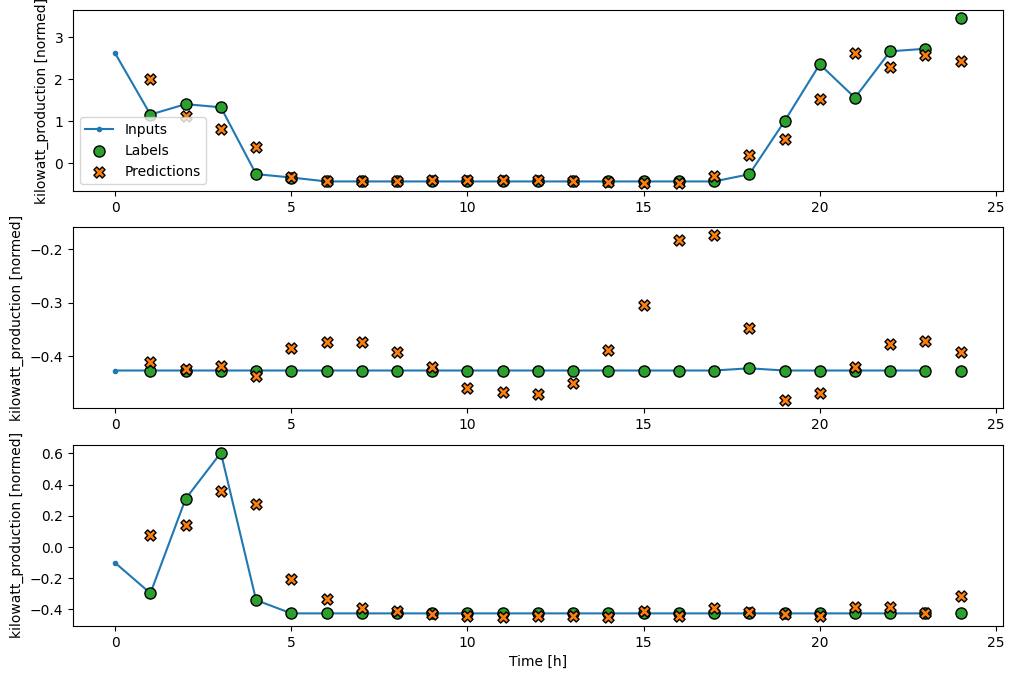

In [ ]:
wide_window.plot(lstm_model, plot_col='kilowatt_production')

#Performance

In [ ]:
cm = lstm_model.metrics[1]
cm.metrics

[<MeanAbsoluteError name=mean_absolute_error>]

In [ ]:
val_performance

{'Baseline': {'loss': 0.6087818145751953,
  'mean_absolute_error': 0.3916459083557129},
 'Linear': {'loss': 0.4704260230064392,
  'mean_absolute_error': 0.40861275792121887},
 'Dense': {'loss': 0.41974228620529175,
  'mean_absolute_error': 0.3377975821495056},
 'Multi step dense': {'loss': 0.40647292137145996,
  'mean_absolute_error': 0.3392411470413208},
 'Conv': {'loss': 0.4041858911514282,
  'mean_absolute_error': 0.33930501341819763},
 'LSTM': {'loss': 0.41429227590560913,
  'mean_absolute_error': 0.3404248356819153}}

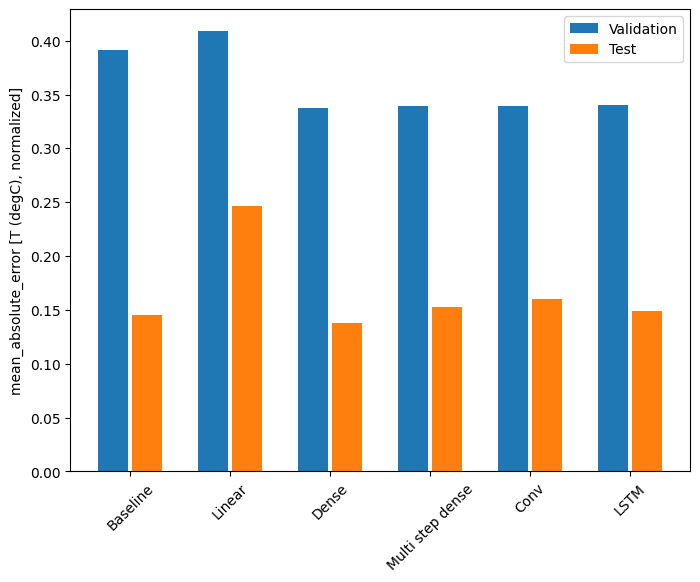

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name:12s}: {value[metric_name]:0.4f}')

Baseline    : 0.1448
Linear      : 0.2466
Dense       : 0.1377
Multi step dense: 0.1523
Conv        : 0.1604
LSTM        : 0.1494


# Multi-output models